What is a GAN?


Generative Adversarial Networks (GANs) are a framework for teaching a deep learning (DL) model to capture the training data's distribution so we can generate new data from that same distribution.

They are made of two distinct models, a generator and a discriminator. The job of the generator is to spawn ‘fake’ images that look like the training images. The job of the discriminator is to look at an image and output whether or not it is a real training image or a fake image from the generator. During training, the generator is constantly trying to outsmart the discriminator by generating better and better fakes, while the discriminator is working to become a better detective and correctly classify the real and fake images. The equilibrium of this game is when the generator is generating perfect fakes that look as if they came directly from the training data, and the discriminator is left to always guess at 50% confidence that the generator output is real or fake.

Now, lets define some notation to be used throughout tutorial starting
with the discriminator. Let $x$ be data representing an image.
$D(x)$ is the discriminator network which outputs the (scalar)
probability that $x$ came from training data rather than the
generator. Here, since we are dealing with images the input to
$D(x)$ is an image of HWC size 3x64x64. Intuitively, $D(x)$
should be HIGH when $x$ comes from training data and LOW when
$x$ comes from the generator. $D(x)$ can also be thought of
as a traditional binary classifier.

For the generator’s notation, let $z$ be a latent space vector
sampled from a standard normal distribution. $G(z)$ represents the
generator function which maps the latent vector $z$ to data-space.
The goal of $G$ is to estimate the distribution that the training
data comes from ($p_{data}$) so it can generate fake samples from
that estimated distribution ($p_g$).

So, $D(G(z))$ is the probability (scalar) that the output of the
generator $G$ is a real image. As described in `Goodfellow’s
paper <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>`__,
$D$ and $G$ play a minimax game in which $D$ tries to
maximize the probability it correctly classifies reals and fakes
($logD(x)$), and $G$ tries to minimize the probability that
$D$ will predict its outputs are fake ($log(1-D(G(x)))$).
From the paper, the GAN loss function is

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(x)))\big]\end{align}





What is a DCGAN?

A DCGAN is a direct extension of the GAN described above, except that it
explicitly uses convolutional and convolutional-transpose layers in the
discriminator and generator, respectively. It was first described by
Radford et. al. in the paper `Unsupervised Representation Learning With
Deep Convolutional Generative Adversarial
Networks <https://arxiv.org/pdf/1511.06434.pdf>`__. The discriminator
is made up of strided
`convolution <https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d>`__
layers, `batch
norm <https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d>`__
layers, and
`LeakyReLU <https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU>`__
activations. The input is a 3x64x64 input image and the output is a
scalar probability that the input is from the real data distribution.
The generator is comprised of
`convolutional-transpose <https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d>`__
layers, batch norm layers, and
`ReLU <https://pytorch.org/docs/stable/nn.html#relu>`__ activations. The
input is a latent vector, $z$, that is drawn from a standard
normal distribution and the output is a 3x64x64 RGB image. The strided
conv-transpose layers allow the latent vector to be transformed into a
volume with the same shape as an image. In the paper, the authors also
give some tips about how to setup the optimizers, how to calculate the
loss functions, and how to initialize the model weights, all of which
will be explained in the coming sections.

In [11]:
#Import libraries and set random seed for reproducibility

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [0]:
#%cd /content/gdrive/My Drive/Kaggle

In [0]:
# ! kaggle datasets download -d jessicali9530/celeba-dataset

In [0]:
# !unzip \*.zip  && rm *.zip

In [0]:
#Input

#dataroot - path to root of dataset folder
#Note, we are ImageFolder dataset class which requires there to be subdirectories in the dataset’s root folder. 
dataroot = "./gdrive/My Drive/Kaggle/img_align_celeba"

#workers -  number of worker threads for loading data for dataloader
workers = 2

#batch_size - as defined in DCGAN paper
batch_size = 128

#image_size - spatial size of images used for training. Here, we are using 64 x 64
image_size = 64

#nc - number of channels. 3 for color (RGB)
nc = 3

#nz - length of z latent vector (ie size of generator input)
nz = 100

#ngf - depth of feature maps in generator
ngf = 64

#ndf - depth of feature maps propogated through discriminator
ndf = 64

#num_epochs
num_epochs = 5

#learning rate for optimizers
lr = 0.0002

#beta1 - hyperparam for Adam optimizers
beta1 = 0.5

#ngpu - number of GPUs available
ngpu = 1

In [19]:
#debug 
 
!ls "./gdrive/My Drive/Kaggle/img_align_celeba/img_align_celeba"

000001.jpg  010481.jpg	020961.jpg  031441.jpg	041921.jpg  052401.jpg
000002.jpg  010482.jpg	020962.jpg  031442.jpg	041922.jpg  052402.jpg
000003.jpg  010483.jpg	020963.jpg  031443.jpg	041923.jpg  052403.jpg
000004.jpg  010484.jpg	020964.jpg  031444.jpg	041924.jpg  052404.jpg
000005.jpg  010485.jpg	020965.jpg  031445.jpg	041925.jpg  052405.jpg
000006.jpg  010486.jpg	020966.jpg  031446.jpg	041926.jpg  052406.jpg
000007.jpg  010487.jpg	020967.jpg  031447.jpg	041927.jpg  052407.jpg
000008.jpg  010488.jpg	020968.jpg  031448.jpg	041928.jpg  052408.jpg
000009.jpg  010489.jpg	020969.jpg  031449.jpg	041929.jpg  052409.jpg
000010.jpg  010490.jpg	020970.jpg  031450.jpg	041930.jpg  052410.jpg
000011.jpg  010491.jpg	020971.jpg  031451.jpg	041931.jpg  052411.jpg
000012.jpg  010492.jpg	020972.jpg  031452.jpg	041932.jpg  052412.jpg
000013.jpg  010493.jpg	020973.jpg  031453.jpg	041933.jpg  052413.jpg
000014.jpg  010494.jpg	020974.jpg  031454.jpg	041934.jpg  052414.jpg
000015.jpg  010495.jpg	020975.jpg 

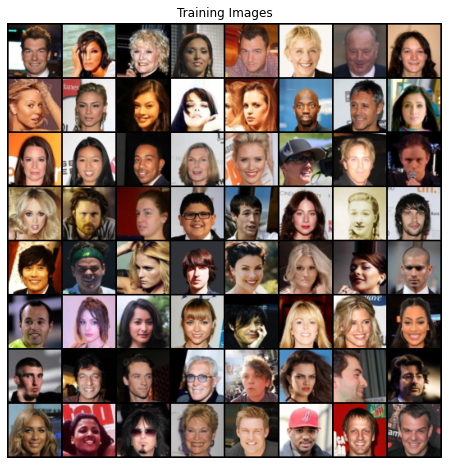

In [20]:
#create the dataset
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

dataset = dset.ImageFolder(root=dataroot, transform=transform)

#create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,
                                         shuffle = True, num_workers = workers)

#set the device to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu >0) else "cpu") 

#Visualize some of the training data.
real_batch = next(iter(dataloader))
plt.figure(figsize = (8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding = 2,normalize = True).cpu(),(1,2,0)))

Implementation is broken down to the following steps


1.   Weight Initialization
2.   Generator
3.   Discriminator
4. Loss Function
5. Training Loop



In [0]:
#Weight Initialisation
#DCGAN Paper specified model weights shall be randomly initialised from a Normal distribution (mean = 0, std = 0.02)

def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

#this function takes an initialised model as input
#reinitialises all convolutional, convolutional-transpose and batch norm layers to meet this criteria.

Generator

The generator, $G$, is designed to map the latent space vector
($z$) to data-space. Since our data are images, converting
$z$ to data-space means ultimately creating a RGB image with the
same size as the training images (i.e. 3x64x64). In practice, this is
accomplished through a series of strided two dimensional convolutional
transpose layers, each paired with a 2d batch norm layer and a relu
activation. The output of the generator is fed through a tanh function
to return it to the input data range of $[-1,1]$. It is worth
noting the existence of the batch norm functions after the
conv-transpose layers, as this is a critical contribution of the DCGAN
paper. These layers help with the flow of gradients during training. An
image of the generator from the DCGAN paper is shown below.

![alt text](https://pytorch.org/tutorials/_images/dcgan_generator.png)

Notice  how the inputs we set in the input section (*nz*, *ngf*, and
*nc*) influence the generator architecture in code. *nz* is the length
of the z input vector, *ngf* relates to the size of the feature maps
that are propagated through the generator, and *nc* is the number of
channels in the output image (set to 3 for RGB images). Below is the
code for the generator.



In [0]:
#Generator Code
# nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
#                    stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')


class Generator(nn.Module):
  def __init__(self,ngpu):
    super(Generator,self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        #input is Z going thru convolution
        nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias = False),
        nn.BatchNorm2d(ngf * 8), #go understand what a Batch Norm layer does
        nn.ReLU(True),
        #state size: (ngf*8) x 4 x 4
        nn.ConvTranspose2d(ngf*8, ngf*4, 4,2,1, bias = False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),
        #state size (ngf*4) x 8 x 8
        nn.ConvTranspose2d(ngf*4, ngf*2, 4,2,1,bias = False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True),
        #state size (ngf*2) x 16 x 16
        nn.ConvTranspose2d(ngf*2, ngf, 4,2,1,bias = False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        #state size (ngf) x 32 x 32
        nn.ConvTranspose2d(ngf, nc, 4,2,1,bias = False),
        nn.Tanh()
        #state size nc x 64 x 64
    )

  def forward(self, input):
    return self.main(input)

In [23]:
#Instantiate Generator and apply weights init
netG = Generator(ngpu).to(device)

#Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

#apply weights_init function
netG.apply(weights_init)

#Print to see the structure
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator

As mentioned, the discriminator, $D$, is a binary classification
network that takes an image as input and outputs a scalar probability
that the input image is real (as opposed to fake). Here, $D$ takes
a 3x64x64 input image, processes it through a series of Conv2d,
BatchNorm2d, and LeakyReLU layers, and outputs the final probability
through a Sigmoid activation function. This architecture can be extended
with more layers if necessary for the problem, but there is significance
to the use of the strided convolution, BatchNorm, and LeakyReLUs. 

The
DCGAN paper mentions it is a good practice to use strided convolution
rather than pooling to downsample because it lets the network learn its
own pooling function. Also batch norm and leaky relu functions promote
healthy gradient flow which is critical for the learning process of both
$G$ and $D$.

In [0]:
#Discriminator
# nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#           dilation=1, groups=1, bias=True, padding_mode='zeros')


class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        #input is nc x 64 x 64
        nn.Conv2d(nc, ndf, 4, 2, 1, bias = False),
        nn.LeakyReLU(0.2, inplace = True), 
        #state size ndf x 32 x 32
        nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2, inplace = True),
        #state size (ndf*2) x 16 x 16
        nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2, inplace = True),
        #state size (ndf*4) x 8 x 8
        nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2, inplace = True),
        #state size (ndf*8) x 4 x 4
        nn.Conv2d(ndf*8, 1, 4, 1, 0, bias = False),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.main(input)


In [25]:
#Initialise and Apply Weights

netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss Functions and Optimizers
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

With $D$ and $G$ setup, we can specify how they learn
through the loss functions and optimizers. We will use the Binary Cross
Entropy loss
(`BCELoss <https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss>`__)
function which is defined in PyTorch as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components
in the objective function (i.e. $log(D(x))$ and
$log(1-D(G(z)))$). We can specify what part of the BCE equation to
use with the $y$ input. This is accomplished in the training loop
which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing $y$
(i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These
labels will be used when calculating the losses of $D$ and
$G$, and this is also the convention used in the original GAN
paper. Finally, we set up two separate optimizers, one for $D$ and
one for $G$. As specified in the DCGAN paper, both are Adam
optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track
of the generator’s learning progression, we will generate a fixed batch
of latent vectors that are drawn from a Gaussian distribution
(i.e. fixed_noise) . In the training loop, we will periodically input
this fixed_noise into $G$, and over the iterations we will see
images form out of the noise.

In [0]:
#initialise BCELoss Function
criterion = nn.BCELoss()

#create batch of latent vectors to visualise progression of generator
fixed_noise = torch.randn(64, nz, 1, 1, device = device)

#establish convention for real and fake labels
real_label = 1
fake_label = 0

#Set up Adam optimisers
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, 0.999))

Training


Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from Goodfellow’s paper, while abiding by some of the best
practices shown in `ganhacks <https://github.com/soumith/ganhacks>`__.
Namely, we will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximize
$logD(G(z))$. Training is split up into two main parts. Part 1
updates the Discriminator and Part 2 updates the Generator.

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
$log(D(x)) + log(1-D(G(z)))$. Due to the separate mini-batch
suggestion from ganhacks, we will calculate this in two steps. 

First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($log(D(x))$), then
calculate the gradients in a backward pass. 

Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by
minimizing $log(1-D(G(z)))$ in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize $log(D(G(z)))$. 

In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$
part) which is exactly what we want.

**Statistic Reporting**

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.




In [29]:
#Training Loop

#Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training...")

for epoch in range(num_epochs):
  #for each batch in dataloader
  for i, data in enumerate(dataloader,0):
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ##Train with all-real batch
    netD.zero_grad()
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, device = device)
    #Forward pass through D
    output = netD(real_cpu).view(-1)
    #Calculate Loss 
    errD_real = criterion(output, label)
    #Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ##Train with all-fake
    #Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device = device)
    #Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    #Classify all fake batch with D
    output = netD(fake.detach()).view(-1)
    #Calculate Loss
    errD_fake = criterion(output, label)
    #Calculate gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()

    # Output training stats
    if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
          fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters += 1


Starting Training...
[0/5][0/492]	Loss_D: 1.3870	Loss_G: 0.7097	D(x): 0.5023	D(G(z)): 0.5027 / 0.4918
[0/5][50/492]	Loss_D: 0.0968	Loss_G: 2.9955	D(x): 0.9608	D(G(z)): 0.0552 / 0.0500
[0/5][100/492]	Loss_D: 0.0301	Loss_G: 4.1834	D(x): 0.9870	D(G(z)): 0.0169 / 0.0153
[0/5][150/492]	Loss_D: 0.0560	Loss_G: 4.3978	D(x): 0.9742	D(G(z)): 0.0291 / 0.0124
[0/5][200/492]	Loss_D: 0.0205	Loss_G: 4.9786	D(x): 0.9908	D(G(z)): 0.0112 / 0.0071
[0/5][250/492]	Loss_D: 0.0142	Loss_G: 5.4316	D(x): 0.9950	D(G(z)): 0.0092 / 0.0044
[0/5][300/492]	Loss_D: 1.1324	Loss_G: 3.2810	D(x): 0.8916	D(G(z)): 0.5871 / 0.0469
[0/5][350/492]	Loss_D: 0.6772	Loss_G: 2.7805	D(x): 0.6870	D(G(z)): 0.2356 / 0.0651
[0/5][400/492]	Loss_D: 1.0966	Loss_G: 2.5992	D(x): 0.4191	D(G(z)): 0.0393 / 0.0927
[0/5][450/492]	Loss_D: 0.5016	Loss_G: 4.0740	D(x): 0.8098	D(G(z)): 0.2273 / 0.0198
[1/5][0/492]	Loss_D: 0.8560	Loss_G: 2.6246	D(x): 0.5688	D(G(z)): 0.1452 / 0.0846
[1/5][50/492]	Loss_D: 0.6387	Loss_G: 5.2844	D(x): 0.8951	D(G(z)): 0.388

In [0]:
#Check results
#1. Changes in D and G's loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label = 'G')
plt.plot(D_losses, label = 'D')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

In [0]:
#2. G's output on the fixed_noise
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated = True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval = 1000, repeat_delay = 1000, blit = True)

HTMLL(ani.to_jshtml())

IndexError: ignored

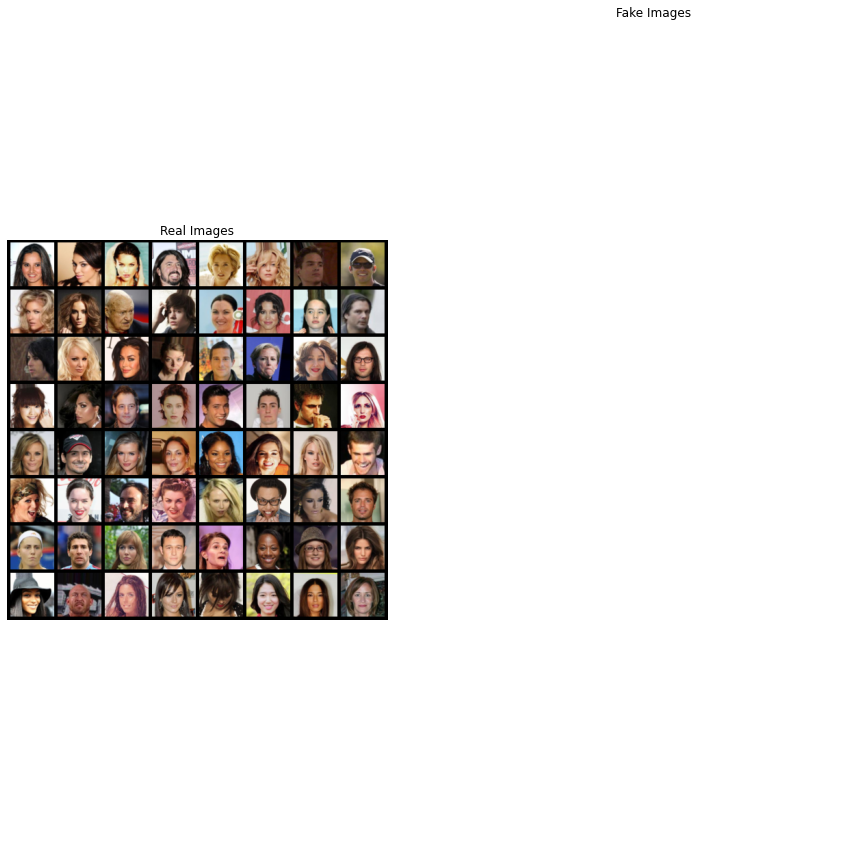

In [28]:
#3. Real vs fake data
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()